In [1]:
import os

import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
from scipy.interpolate import interp1d

from TritonOA.env import env
from TritonOA.models import kraken
from TritonOA.plotting import plotting
from TritonOA.io import readwrite
from TritonOA.sp import signal

## 1. Set Model Configuration

In [61]:
parameters = dict()

# Set Run Type =======================================================================
parameters['fullfield'] = False
parameters['TITLE'] = 'TestMFP'

# Define Geometry ====================================================================
parameters['NMEDIA'] = 1
parameters['ZB'] = 100 # Bottom depth (m)
parameters['NZ'] = 101 # Number of depth points
parameters['Z'] = np.linspace(0, parameters['ZB'], parameters['NZ']) # Depth vector (m)
parameters['RMAX'] = 20 # Maximum range (km)
parameters['dR'] = 500 # Range step (m)
parameters['R'] = np.arange(10, 1000 * parameters['RMAX'] + parameters['dR'], parameters['dR']) # Range vector (m)
parameters['NR'] = len(parameters['R']) # Number of range points
# parameters['X'] = np.arange(0, parameters['RMAX'], 0.001)  # <-------------------------------- ***
parameters['NMESH'] = 0

# Define Source/Receiver ============================================================
parameters['SD'] = 50
# parameters['SR'] = 
parameters['NSD'] = 1
parameters['RD'] = np.linspace(10, 80, 5)
parameters['NRD'] = len(parameters['RD'])
parameters['FREQ'] = 100

# Define Top Boundary =========================================================
parameters['TOPOPT'] = "CVW" # C = Linear SSP interp; V = Vacuum in upper halfspace; W = Wavelength-dependent Attenuation (dB/lambda)
parameters['SIGMA_TOP'] = 0 # RMS roughness (m)

# Define Sound Speed Profile ================================================
# SSP_TYPE = "isospeed"
# [parameters.update({k: v}) for k, v in env.default_SSP(SSP_TYPE, parameters['Z'], CP=1500, RHO=1000, AP=0).items()]
# [print(k, v) for k, v in env.default_SSP(SSP_TYPE, parameters['Z'], CP=1500, RHO=1000, AP=0).items()]
SSP_TYPE = "negative"
[parameters.update({k: v}) for k, v in env.default_SSP(SSP_TYPE, parameters['Z'], CP=1500, dC=100, RHO=1000, AP=0).items()]
# [print(k, v) for k, v in env.default_SSP(SSP_TYPE, parameters['Z'], CP=1490, dC=20, RHO=1000, AP=0).items()]
# SSP_TYPE = "positive"
# [parameters.update({k: v}) for k, v in env.default_SSP(SSP_TYPE, parameters['Z'], CP=1490, dC=50, RHO=1000, AP=0).items()]

# Define Bottom Boundary ======================================================
parameters['BOTOPT'] = "A" # A = Acousto-elastic halfspace
parameters['SIGMA_BOT'] = 0 # RMS roughness (m)
parameters['CPB'] = 1800 # P-wave speed (m/s)
parameters['CSB'] = 400 # S-wave speed (m/s)
parameters['RHOB'] = 1.8 # Density (g/cm3)
parameters['APB'] = 0.1 # P-wave attenuation (dB/kmHz)
parameters['ASB'] = 0.5 # S-wave attenuation (dB/kmHz)

# Phase Speed Limits ============================================================
parameters['CLOW'] = 0 # Lower phase speed limit (m/s)
parameters['CHIGH'] = parameters['CPB']  # Upper phase speed limit (m/s)

fname = 'parameters.p'
_ = readwrite.dict2pkl(parameters, fname)

## 2. Calculate Replica Field

In [62]:
from pathlib import Path

for filename in Path(".").glob(f'{parameters["TITLE"]}.*'):
    filename.unlink()

In [63]:
%%capture cap --no-stderr

# pos, _ = kraken.run_kraken(parameters)

# options = {'fname': f'{parameters["TITLE"]}.mod', 'freq':0}
# M, f = readwrite.read_modes(**options)



P, _ = kraken.build_replica_field(parameters, verbose=False, model="krakenc")
# np.save(f'replicas_{parameters["FREQ"]}', P)    

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:01<00:00, 65.37it/s]


In [64]:
with open(f"{parameters['TITLE']}.prt") as f:
    print(f.read())

 _________________________________________________

 KRAKENC-TestMFP                                                                 
 Nominal Frequency =   100.0    Hz
 NMedia    =   1


     C-Linear approximation to SSP
     Attenuation units: dB/wavelength


   z (m)     alphaR (m/s)   betaR  rho (g/cm^3)  alphaI     betaI

     VACUUM

       ( # mesh points =     0  RMS roughness =   0.00     m )
      0.00      1550.00      0.00   ******       0.0000    0.0000
      1.00      1549.00      0.00   ******       0.0000    0.0000
      2.00      1548.00      0.00   ******       0.0000    0.0000
      3.00      1547.00      0.00   ******       0.0000    0.0000
      4.00      1546.00      0.00   ******       0.0000    0.0000
      5.00      1545.00      0.00   ******       0.0000    0.0000
      6.00      1544.00      0.00   ******       0.0000    0.0000
      7.00      1543.00      0.00   ******       0.0000    0.0000
      8.00      1542.00      0.00   ******       0.0000    0.0000


## 3. Matched Field Processing

### 3.1  Calculate Received (Actual) Pressure Field

In [65]:
sd = 50
sr = 10000

sd_ind = np.where(parameters['Z'] == sd)
sr_ind = np.where(np.isclose(parameters['R'], sr, atol=parameters['dR']/2))
# sr_ind = np.where(parameters['R'] == sr)

received = np.moveaxis(
    P[sd_ind, sr_ind, :].squeeze(axis=0),
    0, -1
)

K = received @ received.conj().T
np.save('received', received)

### 3.2 Perform Grid Search

In [66]:
rvec = parameters['R']
zvec = parameters['Z']
# zvec = np.arange(0, 101)
B = np.zeros((parameters['NZ'], parameters['NR']))

for nn, r in enumerate(rvec):
    for mm, z in enumerate(zvec):
        received_hat = P[np.where(parameters['Z'] == z), np.where(parameters['R'] == r), :].squeeze()
        B[mm, nn] = signal.bartlett(K, received_hat)
#         w = received_hat / np.linalg.norm(received_hat)
#         B[mm, nn] = abs(w.conj().T @ K @ w)



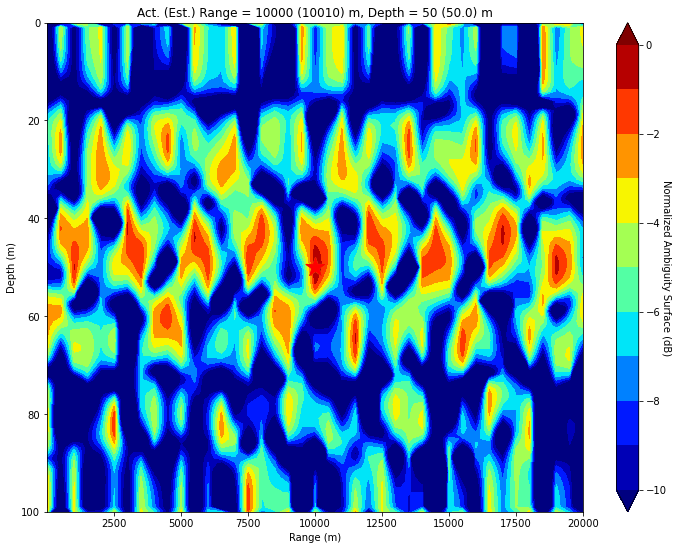

In [67]:
def plot_MFP(
        asurf,
        rvec,
        zvec,
        vlim=[-10, 0],
        figsize=(12, 9),
        sr=None,
        sd=None,
        show=True
    ):

    fig = plt.figure(figsize=figsize)
    # Plot ambiguity surface:
#     plt.imshow(
#         nasurfdb,
#         aspect='auto',
#         extent=[min(rvec), max(rvec), min(zvec), max(zvec)],
#         origin='lower',
#         vmin=vlim[0],
#         vmax=vlim[1],
#         interpolation='none',
#         cmap='jet'
#     )
    plt.contourf(
        rvec, zvec,
        nasurfdb,
        levels=np.linspace(-10, 0, 11),
        cmap='jet',
        origin='lower',
        extend='both'
    )
    plt.gca().invert_yaxis()
    plt.xlabel("Range (m)")
    plt.ylabel("Depth (m)")
    cbar = plt.colorbar()
    cbar.set_label('Normalized Ambiguity Surface (dB)', rotation=270)

    # Plot MFP localization:
    sd_ind_est, sr_ind_est = np.unravel_index(np.argmax(nasurfdb), (len(zvec), len(rvec)))
    plt.scatter(rvec[sr_ind_est], zvec[sd_ind_est], c='y', s=20**2, marker='*')

    # Plot actual location:
    if (sr is not None) and (sd is not None):
        plt.scatter(sr, sd, c='r', s=20**2, marker='*')
    
    plt.title(f'Act. (Est.) Range = {sr} ({rvec[sr_ind_est]}) m, Depth = {sd} ({zvec[sd_ind_est]}) m')

    if show:
        plt.show()
    else:
        plt.close()
    return fig


asurf = B
nasurf = asurf / np.max(asurf)
nasurfdb = 10 * np.log10(nasurf)

fig = plot_MFP(nasurfdb, rvec, zvec, sr=sr, sd=sd)

## Appendix A: Test MFP on Swellex Data

In [69]:
import scipy.io as sio

data = sio.loadmat('zreplica_250.mat')
p1 = data['p1']
rr = data['rr'].squeeze()
rd = data['rd'].squeeze()
sd = data['sd'].squeeze()


sr = 3e3
sd = 40

r = np.expand_dims(p1[np.where(rd==sd), np.where(rr==sr), :].squeeze(), axis=1)
K = r @ r.conj().T

asurf = np.zeros((len(rd), len(rr)))

for mm in range(len(rr)):

    for nn in range(len(rd)):
        asurf[nn, mm] = signal.bartlett(K, p1[nn, mm, :].squeeze())

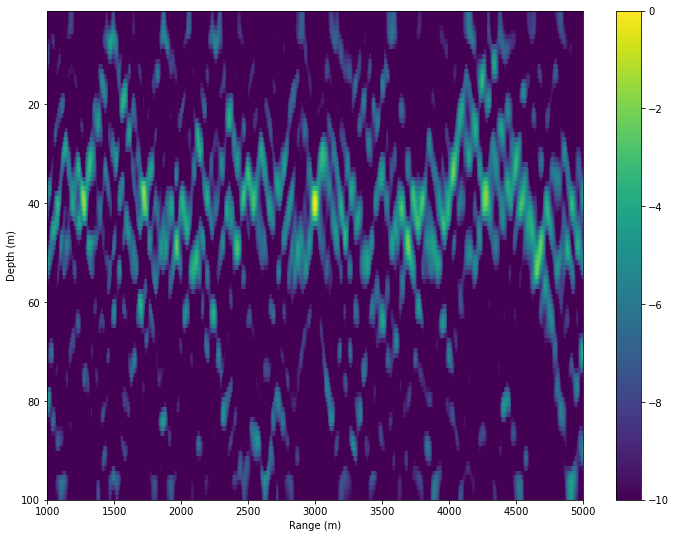

In [13]:
nasurf = asurf / np.max(asurf)
lognasurf = 10 * np.log10(nasurf)

fig = plt.figure(figsize=(12,9))
plt.imshow(lognasurf, aspect='auto', origin='lower', extent=[rr.min(), rr.max(), rd.min(), rd.max()], interpolation='none', vmin=-10, vmax=0)
plt.gca().invert_yaxis()
plt.xlabel('Range (m)')
plt.ylabel('Depth (m)')
plt.colorbar()
plt.show()